<a href="https://colab.research.google.com/drive/1vKxH3JJ6TLv63y3kwTZ7VQzVo2EJPZqg#scrollTo=1mbkt9ohRPDh" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Clone Repo

In [1]:
!git clone https://github.com/Depanshu-Sani/SICKLE.git

Cloning into 'SICKLE'...
remote: Enumerating objects: 153, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 153 (delta 69), reused 137 (delta 59), pack-reused 0
Receiving objects: 100% (153/153), 2.17 MiB | 9.49 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [2]:
%cd SICKLE

/content/SICKLE


# Get the dataset
### You have to get the access using [this](https://docs.google.com/forms/d/e/1FAIpQLSdq7Dcj5FF1VmlKozrQ7XNoq006iVKrUIMTK2jReBJDuO1N2g/viewform) form. After that create a shortcut of drive folder to your drive and use the path below

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
%%capture
!unzip /content/drive/MyDrive/WACV\ 2024/sickle_toy_dataset.zip

In [18]:
%%capture
!unzip /content/drive/MyDrive/WACV\ 2024/weights.zip

# Requirements

In [6]:
%%capture
!pip install -r requirements.txt

In [7]:
! chmod 777 ./*

In [20]:
!./train.sh sickle_toy_dataset/ [S1,S2] unet3d

> SEEDING DONE 0
Namespace(model='unet3d', encoder_widths=[64, 128], decoder_widths=[32, 128], out_conv=[32, 16], str_conv_k=4, str_conv_s=2, str_conv_p=1, agg_mode='att_group', encoder_norm='group', n_head=16, d_model=256, d_k=4, device='cuda', num_workers=8, seed=0, epochs=100, batch_size=32, lr=0.1, num_classes=1, ignore_index=-999, pad_value=0, padding_mode='reflect', resume='', run_id='', wandb=False, satellites={'S1': {'bands': ['VV', 'VH'], 'rgb_bands': [0, 1, 0], 'mask_res': 10, 'img_size': (32, 32)}, 'S2': {'bands': ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'], 'rgb_bands': [3, 2, 1], 'mask_res': 10, 'img_size': (32, 32)}}, run_name='[S1,S2]_unet3d', exp_name='sowing_date', task='sowing_date', actual_season=False, data_dir='sickle_toy_dataset/', use_augmentation=True, cache=False, run_path='runs/wacv_2024_seed0/sowing_date/[S1,S2]_unet3d', primary_sat='S1', img_size=(32, 32))
-----------S1------------
Samples Shape torch.Size([28, 23, 2, 32, 32])

# Main Code

In [9]:
import argparse
import json
import os
import copy
import pprint

import time
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Custom import
from utils.dataset import SICKLE_Dataset
from utils import utae_utils, model_utils
from utils.weight_init import weight_init
from utils.metric import get_metrics, RMSELoss
from evaluate import iterate as val_iter
from train import iterate as train_iter

# torch
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchnet as tnt

In [10]:
def set_seed(seed=42):
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

    # For reproducibility
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    try:
        torch.use_deterministic_algorithms(True, warn_only=True)
    except Exception as e:
        print("Can not use deterministic algorithm. Error: ", e)
    print(f"> SEEDING DONE {seed}")

In [11]:
def get_data_loaders():
  # Dataset definition
    data_dir = CFG.data_dir
    df = pd.read_csv(os.path.join(data_dir,"sickle_dataset_tabular.csv"))

    if CFG.task != "crop_type":
        df = df[df.YIELD > 0].reset_index(drop=True)

    train_df = df[df.SPLIT == "train"].reset_index(drop=True)
    val_df = df[df.SPLIT == "val"].reset_index(drop=True)
    test_df = df[df.SPLIT == "test"].reset_index(drop=True)

    dt_args = dict(
        data_dir=data_dir,
        satellites=CFG.satellites,
        ignore_index=CFG.ignore_index,
        transform=CFG.use_augmentation,
        actual_season=CFG.actual_season
    )

    dt_train = SICKLE_Dataset(df=train_df, phase="train", **dt_args)
    dt_args = dict(
        data_dir=data_dir,
        satellites=CFG.satellites,
        ignore_index=CFG.ignore_index,
        actual_season=CFG.actual_season
    )
    dt_val = SICKLE_Dataset(df=val_df, **dt_args, )
    dt_test = SICKLE_Dataset(df=test_df, **dt_args)

    collate_fn = lambda x: utae_utils.pad_collate(x, pad_value=CFG.pad_value)
    train_loader = data.DataLoader(
        dt_train,
        batch_size=CFG.batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=CFG.num_workers,
    )
    val_loader = data.DataLoader(
        dt_val,
        batch_size=CFG.batch_size,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=CFG.num_workers,
    )
    test_loader = data.DataLoader(
        dt_test,
        batch_size=CFG.batch_size,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=CFG.num_workers,
    )
    batch_data, masks = next(iter(train_loader))
    for sat in CFG.satellites.keys():
        (samples, dates) = batch_data[sat]
        print(f"-----------{sat}------------")
        print("Samples Shape", samples.shape, "Masks Shape", masks["crop_type"].shape)
        print("dates", dates[0])
        print("Samples", torch.unique(samples[0]))
        print("Masks", torch.unique(masks[CFG.task]))

    print(
        "Train {}, Val {}, Test {}".format(len(dt_train), len(dt_val), len(dt_test))
    )
    return train_loader, val_loader, test_loader

In [12]:
def val(CFG):
    device = CFG.device
    train_loader, val_loader, test_loader = get_data_loaders()

    model = model_utils.Fusion_model(CFG)
    model.apply(weight_init)
    model = model.to(device)
    CFG.N_params = utae_utils.get_ntrainparams(model)
    print("TOTAL TRAINABLE PARAMETERS :", CFG.N_params)

    # Optimizer, Loss and Scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr)
    if CFG.task == "crop_type":
        criterion = nn.CrossEntropyLoss(ignore_index=CFG.ignore_index,
                                        weight=torch.tensor([0.62013, 0.37987])).to(device=CFG.device, dtype=torch.float32)
    else:
        criterion = RMSELoss(ignore_index=CFG.ignore_index)
    scheduler = CosineAnnealingLR(optimizer, T_max=3 * CFG.epochs // 4, eta_min=1e-4)

    best_checkpoint = torch.load(
        os.path.join(
            CFG.best_path, "checkpoint_best.pth.tar"
        )
    )
    model.load_state_dict(best_checkpoint["model"])

    model.eval()
    val_loss, val_metrics, _ = val_iter(
        model,
        data_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        mode="val",
        device=device,
        task=CFG.task,
        log=True,
        CFG=CFG,
    )
    print(f"val Result {CFG.task}")
    if CFG.task == "crop_type":
        # val metric
        val_f1_macro, val_acc, val_iou, val_f1_paddy, val_f1_non_paddy, \
        val_acc_paddy, val_acc_non_paddy, val_iou_paddy, val_iou_non_paddy, _ = val_metrics
        deciding_metric = val_f1_macro
        # log and print metrics
        print(
            f"F1: {val_f1_macro:0.4f} | Paddy F1: {val_f1_paddy:0.4f} | Non-Paddy F1: {val_f1_non_paddy:0.4f} \nAcc:{val_acc:0.4f} | Paddy Acc: {val_acc_paddy:0.4f} | Non-Paddy Acc: {val_acc_non_paddy:0.4f}\niou:{val_iou:0.4f} | Paddy iou: {val_iou_paddy:0.4f} | Non-Paddy iou: {val_iou_non_paddy:0.4f}")

    else:
        # val metrics
        val_rmse, val_mae, val_mape = val_metrics
        print(f"val RMSE: {val_rmse:0.4f} | val MAE: {val_mae:0.4f} | val MAPE: {val_mape:0.4f}")
        vallog = {
            "val_loss": val_loss,
            "val_rmse": val_rmse.item(),
            "val_mae": val_mae.item(),
            "val_mape": val_mape.item(),
        }

def train(CFG):
    device = CFG.device

    train_loader, val_loader, test_loader = get_data_loaders()

    model = model_utils.Fusion_model(CFG)
    model.apply(weight_init)
    model = model.to(device)
    CFG.N_params = utae_utils.get_ntrainparams(model)
    print("TOTAL TRAINABLE PARAMETERS :", CFG.N_params)

    # Optimizer, Loss and Scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr)
    if CFG.task == "crop_type":
        criterion = nn.CrossEntropyLoss(ignore_index=CFG.ignore_index,
                                        weight=torch.tensor([0.62013, 0.37987])).to(device=CFG.device, dtype=torch.float32)
    else:
        criterion = RMSELoss(ignore_index=CFG.ignore_index)
    scheduler = CosineAnnealingLR(optimizer, T_max=3 * CFG.epochs // 4, eta_min=1e-4)

    # Training loop
    trainlog = {}
    best_metric = 0 if CFG.task == "crop_type" else torch.inf
    for epoch in range(1, CFG.epochs + 1):
        print("EPOCH {}/{}".format(epoch, CFG.epochs))
        model.train()
        train_loss, train_metrics = train_iter(
            model,
            data_loader=train_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            mode="train",
            device=device,
            epoch=epoch,
            task=CFG.task,
            CFG = CFG,
        )

        print("Validation . . . ")
        model.eval()
        val_loss, val_metrics = train_iter(
            model,
            data_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            mode="val",
            device=device,
            task=CFG.task,
            CFG = CFG,

        )
        lr = optimizer.param_groups[0]['lr']
        if CFG.task == "crop_type":
            # train metrics
            train_f1_macro, train_acc, train_iou, train_f1_paddy, train_f1_non_paddy, \
            train_acc_paddy, train_acc_non_paddy, train_iou_paddy, train_iou_non_paddy, _ = train_metrics
            # val metric
            val_f1_macro, val_acc, val_iou, val_f1_paddy, val_f1_non_paddy, \
            val_acc_paddy, val_acc_non_paddy, val_iou_paddy, val_iou_non_paddy, _ = val_metrics
            deciding_metric = val_f1_macro
            # log and print metrics
            print(
                f"F1: {val_f1_macro:0.4f} | Paddy F1: {val_f1_paddy:0.4f} | Non-Paddy F1: {val_f1_non_paddy:0.4f} \nAcc:{val_acc:0.4f} | Paddy Acc: {val_acc_paddy:0.4f} | Non-Paddy Acc: {val_acc_non_paddy:0.4f}\niou:{val_iou:0.4f} | Paddy iou: {val_iou_paddy:0.4f} | Non-Paddy iou: {val_iou_non_paddy:0.4f}")
        else:
            # train metrics
            train_rmse, train_mae, train_mape = train_metrics
            # val metrics
            val_rmse, val_mae, val_mape = val_metrics
            deciding_metric = val_mae
            print(f"Val RMSE: {val_rmse:0.4f} | Val MAE: {val_mae:0.4f} | Val MAPE: {val_mape:0.4f}")

        if (deciding_metric > best_metric and CFG.task == "crop_type") or (
                deciding_metric < best_metric and CFG.task != "crop_type"):
            print(f"Valid Score Improved ({best_metric:0.4f} ---> {deciding_metric:0.4f})")
            best_metric = deciding_metric


In [13]:
class CFG:
    model='utae'
    encoder_widths=[64, 128]
    decoder_widths=[32, 128]
    out_conv=[32, 16]
    str_conv_k=4
    str_conv_s=2
    str_conv_p=1
    agg_mode='att_group'
    encoder_norm='group'
    n_head=16
    d_model=256
    d_k=4
    padding_mode='reflect'
    # SICKLE Specific Parameters
    device="cuda" if torch.cuda.is_available() else "cpu"
    num_workers=2
    seed=0
    epochs=10
    batch_size=32
    lr=0.1
    num_classes=2
    ignore_index=-999
    pad_value=0
    resume=''
    run_id=''
    debug=False
    actual_season=False
    use_augmentation=True
    cache=False


CFG.satellites=["S1"]
CFG.task='crop_type'
CFG.run_name = f'{CFG.satellites}_{CFG.model}'
CFG.data_dir='/content/SICKLE/sickle_toy_dataset'
CFG.run_path='/content/SICKLE/runs/wacv_2024/crop_type/[S1]_utae'
CFG.best_path='/content/SICKLE/runs/wacv_2024/crop_type/[S1]_utae'
CFG.exp_name = CFG.task

CFG.run_path = f"runs/wacv_2024_seed{CFG.seed}/{CFG.exp_name}/{CFG.run_name}"

satellite_metadata = {
    "S2": {
        "bands": ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'],
        "rgb_bands": [3, 2, 1],
        "mask_res": 10,
        "img_size": (32, 32),
    },
    "S1": {
        "bands": ['VV', 'VH'],
        "rgb_bands": [0, 1, 0],
        "mask_res": 10,
        "img_size": (32, 32),
    },
    "L8": {
        "bands": ["SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7", "ST_B10"],
        "rgb_bands": [3, 2, 1],
        "mask_res": 10,
        "img_size": (32, 32),
    },
}

required_sat_data = {}
for satellite in CFG.satellites:
    required_sat_data[satellite] = satellite_metadata[satellite]
CFG.satellites = required_sat_data

# first satellie is primary, img_size and mask_res is decided by it
CFG.primary_sat =list(required_sat_data.keys())[0]
CFG.img_size = required_sat_data[CFG.primary_sat]["img_size"]
set_seed(CFG.seed)

> SEEDING DONE 0


# Validation and Training

-----------S1------------
Samples Shape torch.Size([32, 23, 2, 32, 32]) Masks Shape torch.Size([32, 32, 32])
dates tensor([  4,  16,  28,  40,  52,  64,  70,  76, 100, 124, 136, 148, 160, 172,
          0,   0,   0,   0,   0,   0,   0,   0,   0])
Samples tensor([-41.8329, -41.6802, -41.4396,  ...,  -3.6149,  -3.4873,   0.0000])
Masks tensor([-999.,    0.,    1.], dtype=torch.float64)
Train 194, Val 23, Test 0
TOTAL TRAINABLE PARAMETERS : 1060738


Val_Crop_Type: 100%|██████████| 1/1 [00:15<00:00, 15.03s/it, Loss=0.3555, gpu_mem=0.99 GB]

val Result crop_type
F1: 0.8182 | Paddy F1: 0.7033 | Non-Paddy F1: 0.9331 
Acc:0.8908 | Paddy Acc: 0.7273 | Non-Paddy Acc: 0.9262
iou:0.7085 | Paddy iou: 0.5424 | Non-Paddy iou: 0.8746


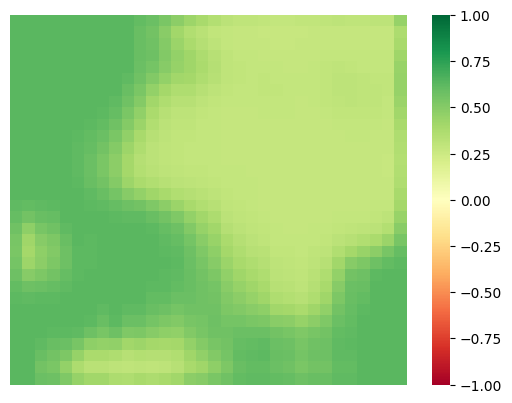

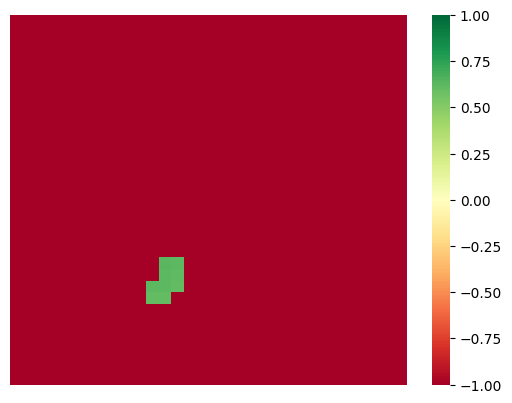

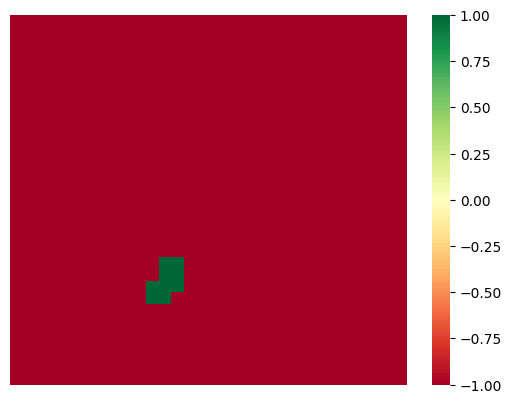

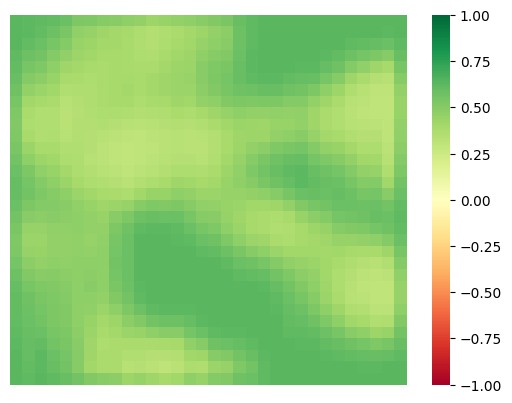

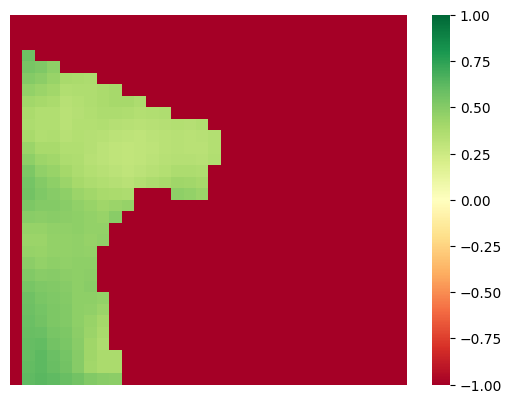

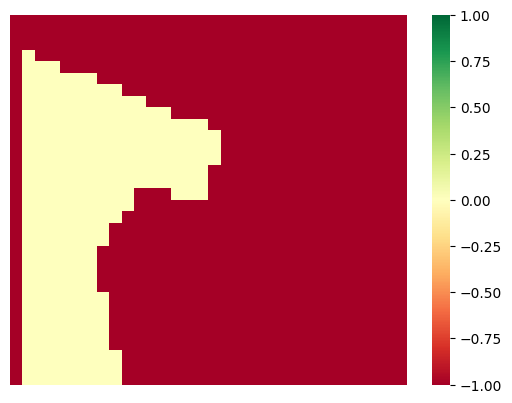

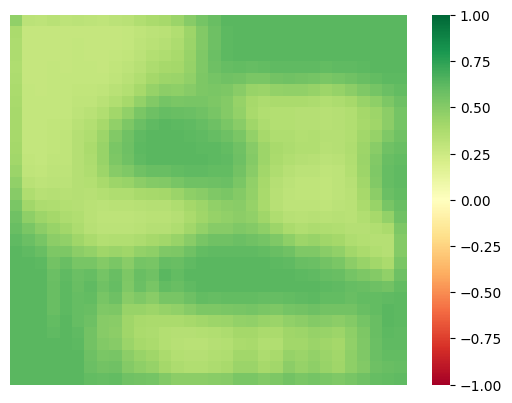

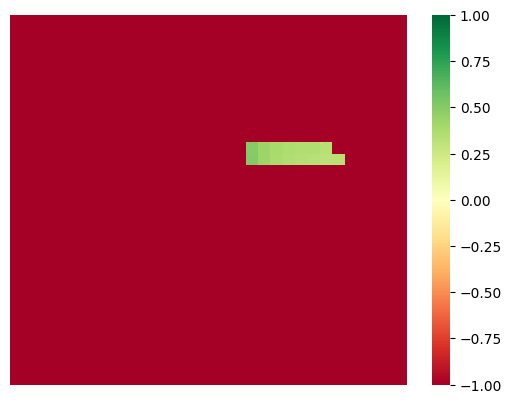

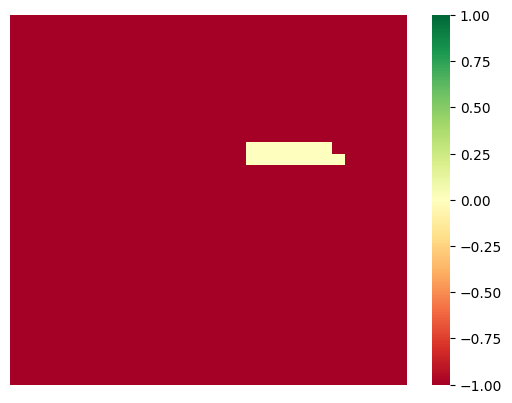

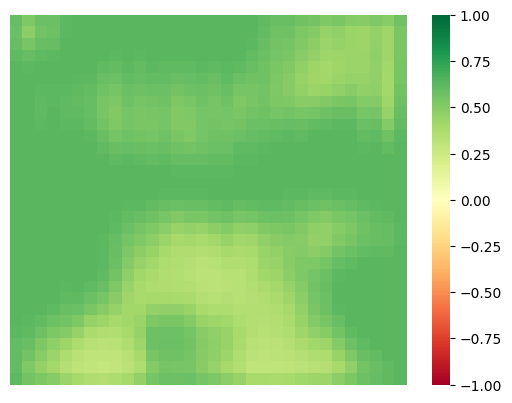

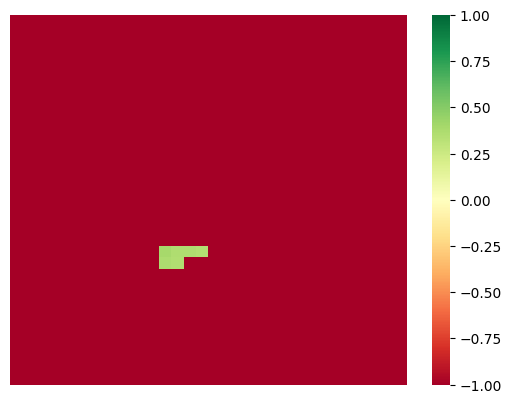

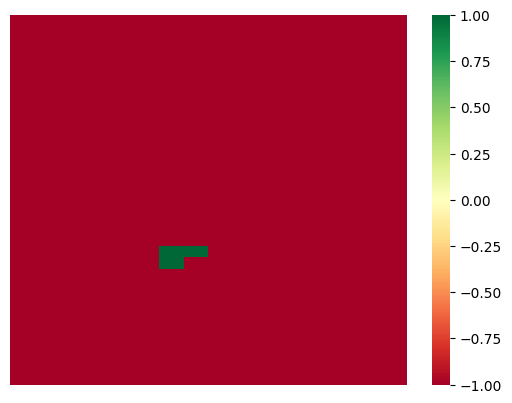

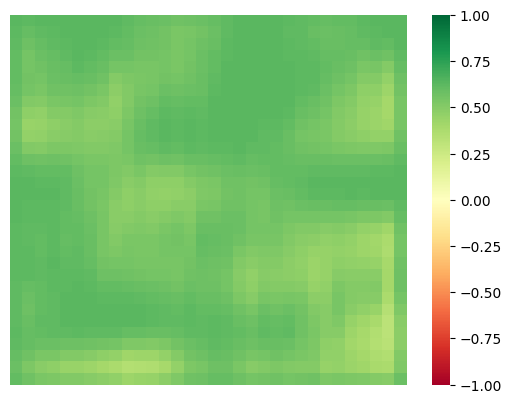

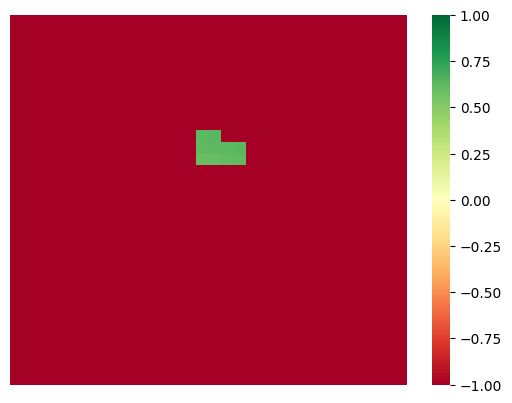

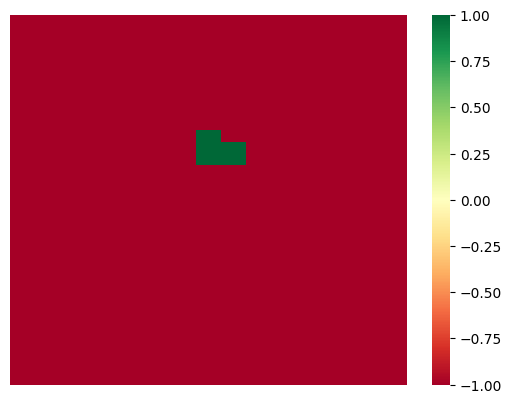

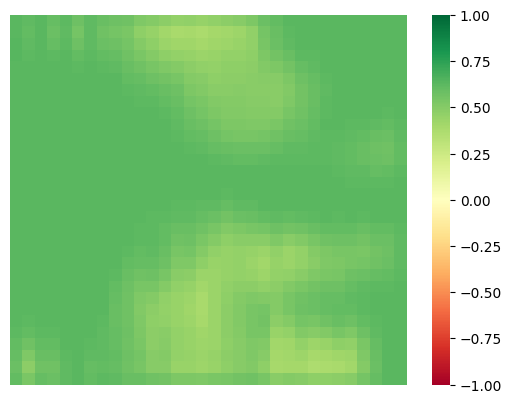

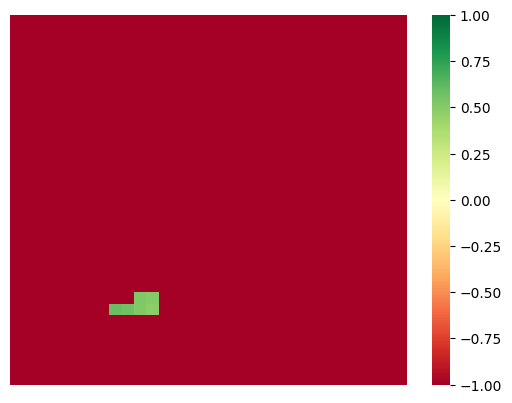

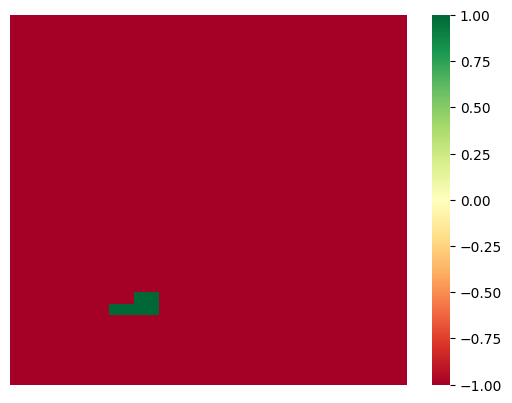

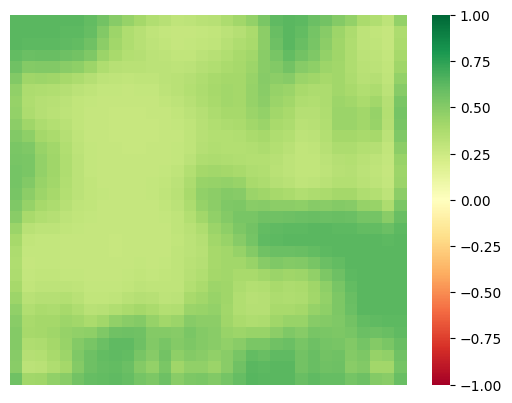

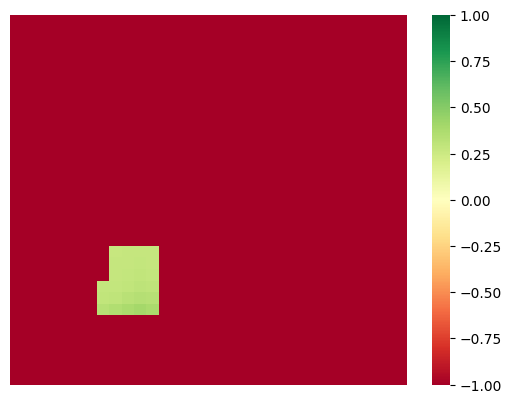

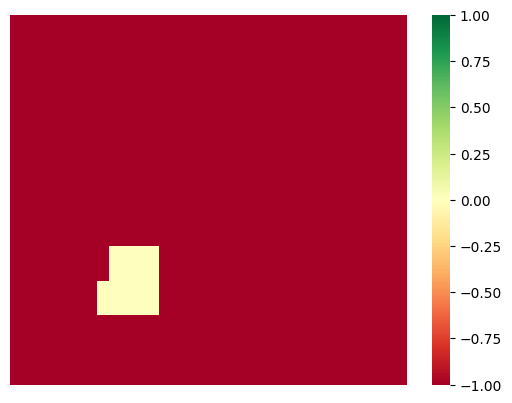

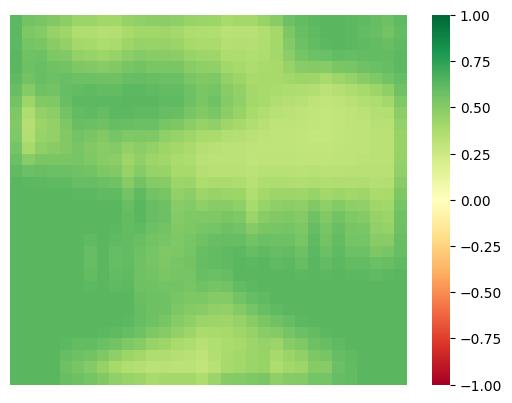

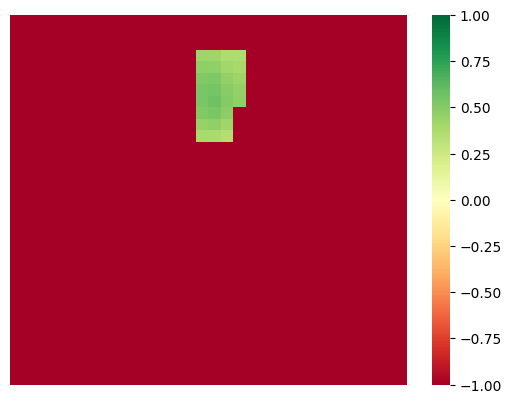

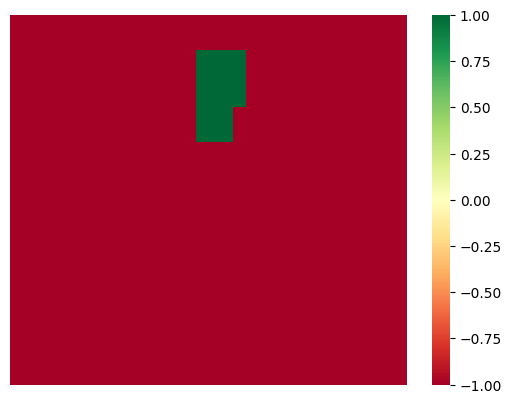

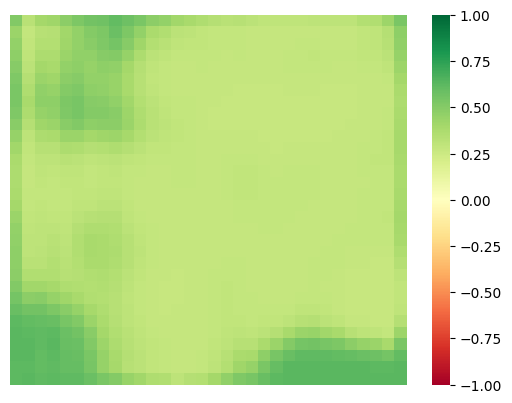

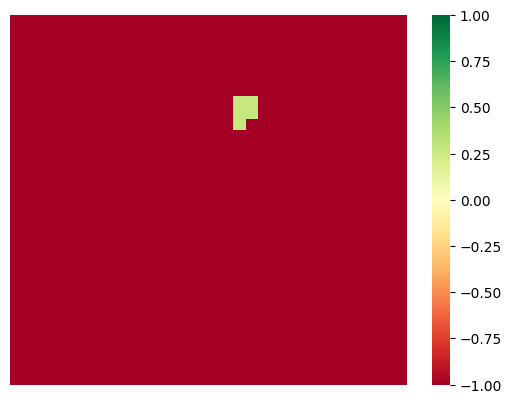

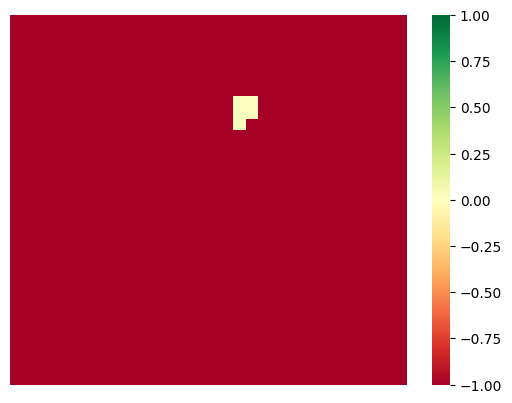

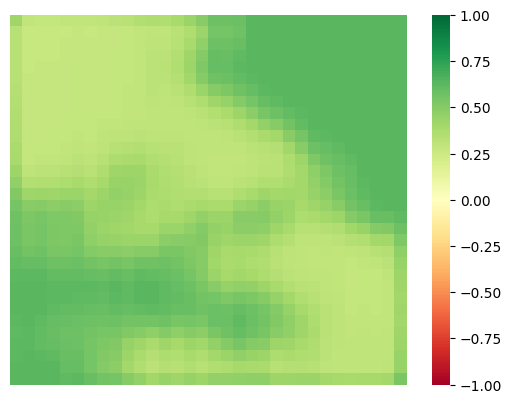

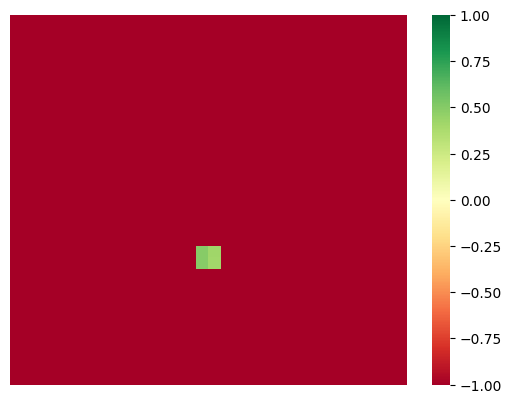

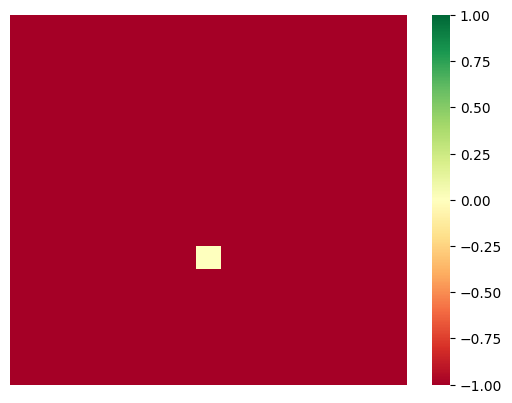

In [14]:
val(CFG)

In [15]:
train(CFG)

-----------S1------------
Samples Shape torch.Size([32, 23, 2, 32, 32]) Masks Shape torch.Size([32, 32, 32])
dates tensor([  9,  21,  33,  57,  69,  81,  93, 105, 117, 129, 141, 153, 165, 177,
          0,   0,   0,   0,   0,   0,   0,   0,   0])
Samples tensor([-49.4443, -44.4791, -43.4562,  ...,  -0.8202,  -0.5070,   0.0000])
Masks tensor([-999.,    0.,    1.], dtype=torch.float64)
Train 194, Val 23, Test 0
TOTAL TRAINABLE PARAMETERS : 1060738
EPOCH 1/10


train: 100%|██████████| 7/7 [00:05<00:00,  1.23it/s, Loss=0.7349, gpu_mem=3.77 GB]

Epoch time : 5.8s
Validation . . . 



val: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s, Loss=1443.5586, gpu_mem=3.77 GB]

Epoch time : 1.0s
F1: 0.1511 | Paddy F1: 0.3021 | Non-Paddy F1: 0.0000 
Acc:0.1780 | Paddy Acc: 1.0000 | Non-Paddy Acc: 0.0000
iou:0.0890 | Paddy iou: 0.1780 | Non-Paddy iou: 0.0000
Valid Score Improved (0.0000 ---> 0.1511)
EPOCH 2/10



train: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s, Loss=0.7317, gpu_mem=3.77 GB]


Epoch time : 5.4s
Validation . . . 


val: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it, Loss=1157.7885, gpu_mem=3.77 GB]

Epoch time : 1.3s
F1: 0.1511 | Paddy F1: 0.3021 | Non-Paddy F1: 0.0000 
Acc:0.1780 | Paddy Acc: 1.0000 | Non-Paddy Acc: 0.0000
iou:0.0890 | Paddy iou: 0.1780 | Non-Paddy iou: 0.0000
EPOCH 3/10



train: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s, Loss=0.2880, gpu_mem=3.77 GB]

Epoch time : 5.4s
Validation . . . 



val: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, Loss=680.4742, gpu_mem=3.77 GB]

Epoch time : 1.0s
F1: 0.1511 | Paddy F1: 0.3021 | Non-Paddy F1: 0.0000 
Acc:0.1780 | Paddy Acc: 1.0000 | Non-Paddy Acc: 0.0000
iou:0.0890 | Paddy iou: 0.1780 | Non-Paddy iou: 0.0000
EPOCH 4/10



train: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s, Loss=0.5255, gpu_mem=3.77 GB]


Epoch time : 5.2s
Validation . . . 


val: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it, Loss=76.3615, gpu_mem=3.77 GB]

Epoch time : 1.3s
F1: 0.1511 | Paddy F1: 0.3021 | Non-Paddy F1: 0.0000 
Acc:0.1780 | Paddy Acc: 1.0000 | Non-Paddy Acc: 0.0000
iou:0.0890 | Paddy iou: 0.1780 | Non-Paddy iou: 0.0000
EPOCH 5/10



train: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s, Loss=0.6793, gpu_mem=3.77 GB]

Epoch time : 5.6s
Validation . . . 



val: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it, Loss=10.2848, gpu_mem=3.77 GB]

Epoch time : 1.4s
F1: 0.2541 | Paddy F1: 0.3250 | Non-Paddy F1: 0.1832 
Acc:0.2609 | Paddy Acc: 1.0000 | Non-Paddy Acc: 0.1009
iou:0.1475 | Paddy iou: 0.1940 | Non-Paddy iou: 0.1009
Valid Score Improved (0.1511 ---> 0.2541)
EPOCH 6/10



train: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s, Loss=0.6095, gpu_mem=3.77 GB]

Epoch time : 5.5s
Validation . . . 



val: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it, Loss=0.9078, gpu_mem=3.77 GB]

Epoch time : 1.3s
F1: 0.4166 | Paddy F1: 0.3399 | Non-Paddy F1: 0.4933 
Acc:0.4267 | Paddy Acc: 0.8295 | Non-Paddy Acc: 0.3395
iou:0.2661 | Paddy iou: 0.2048 | Non-Paddy iou: 0.3274
Valid Score Improved (0.2541 ---> 0.4166)
EPOCH 7/10



train: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s, Loss=0.3811, gpu_mem=3.77 GB]

Epoch time : 5.4s
Validation . . . 



val: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, Loss=0.7251, gpu_mem=3.77 GB]

Epoch time : 1.0s
F1: 0.3113 | Paddy F1: 0.3398 | Non-Paddy F1: 0.2827 
Acc:0.3124 | Paddy Acc: 0.9943 | Non-Paddy Acc: 0.1648
iou:0.1846 | Paddy iou: 0.2047 | Non-Paddy iou: 0.1646
EPOCH 8/10



train: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s, Loss=0.7298, gpu_mem=4.31 GB]


Epoch time : 5.4s
Validation . . . 


val: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it, Loss=0.6530, gpu_mem=4.31 GB]

Epoch time : 1.3s
F1: 0.4308 | Paddy F1: 0.3772 | Non-Paddy F1: 0.4843 
Acc:0.4358 | Paddy Acc: 0.9602 | Non-Paddy Acc: 0.3223
iou:0.2760 | Paddy iou: 0.2325 | Non-Paddy iou: 0.3195
Valid Score Improved (0.4166 ---> 0.4308)
EPOCH 9/10



train: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s, Loss=0.7107, gpu_mem=4.31 GB]

Epoch time : 5.5s
Validation . . . 



val: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, Loss=0.6180, gpu_mem=4.31 GB]

Epoch time : 1.0s
F1: 0.4694 | Paddy F1: 0.3540 | Non-Paddy F1: 0.5847 
Acc:0.4944 | Paddy Acc: 0.7784 | Non-Paddy Acc: 0.4330
iou:0.3141 | Paddy iou: 0.2151 | Non-Paddy iou: 0.4131
Valid Score Improved (0.4308 ---> 0.4694)
EPOCH 10/10



train: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s, Loss=0.6571, gpu_mem=4.31 GB]


Epoch time : 5.5s
Validation . . . 


val: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it, Loss=0.6058, gpu_mem=4.31 GB]

Epoch time : 1.3s
F1: 0.4973 | Paddy F1: 0.3636 | Non-Paddy F1: 0.6310 
Acc:0.5329 | Paddy Acc: 0.7500 | Non-Paddy Acc: 0.4859
iou:0.3416 | Paddy iou: 0.2222 | Non-Paddy iou: 0.4609
Valid Score Improved (0.4694 ---> 0.4973)
